# TP 02 - Le Mécanisme d'Attention

**Module** : Réseaux de Neurones Approfondissement  
**Durée** : 2h  
**Objectif** : Comprendre et implémenter le mécanisme d'attention, brique fondamentale des Transformers

---

## Objectifs pédagogiques

À la fin de ce TP, vous serez capable de :
1. Expliquer intuitivement ce qu'est l'attention
2. Comprendre les concepts de Query, Key, Value
3. Implémenter le Scaled Dot-Product Attention
4. Visualiser et interpréter les poids d'attention

---

## Prérequis

Ce TP suppose que vous avez complété le **TP 01 - Fondamentaux NLP** où vous avez découvert :
- La tokenization (comment transformer du texte en nombres)
- Les embeddings (représentations vectorielles des mots)
- Word2Vec et la similarité sémantique
- Un premier aperçu de l'attention

Ici, nous allons **approfondir le mécanisme d'attention** et l'implémenter from scratch.

## 0. Installation et imports

Exécutez cette cellule pour installer les dépendances nécessaires.

In [2]:
# Installation des dépendances (Google Colab)
!pip install torch matplotlib numpy transformers -q

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Configuration
torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
GPU disponible: False


## 1. Rappel du TP1 : Ce qu'on a construit

Dans le TP1, on a vu comment on pouvait calculer les embeddings pour représenter des mots.

✅ **Ce qu'on a résolu** :
- Représenter les mots comme des vecteurs denses
- Capturer la similarité sémantique (ex: Pikachu proche d'Électrik)
- Créer des analogies (Salamèche - Feu + Eau ≈ Carapuce)

❌ **Problèmes restants** :

**1. L'ORDRE n'est pas encodé**
```
"Le chat mange la souris" → [emb_Le, emb_chat, emb_mange, emb_la, emb_souris]
"La souris mange le chat" → [emb_La, emb_souris, emb_mange, emb_le, emb_chat]
```
→ Mêmes embeddings, juste dans un ordre différent. Le modèle ne "voit" pas cette différence !

**2. Pas de CONTEXTE**
```
"Le chat dort" → emb_chat = [0.2, 0.5, ...]
"Le chat mange" → emb_chat = [0.2, 0.5, ...]  ← même vecteur !
```
→ Le mot "chat" a toujours la même représentation, quel que soit le contexte.

💡 **Solutions (ce TP)** :
1. **Positional Encoding** → ajoute l'information de position
2. **Mécanisme d'Attention** → permet à chaque mot de "regarder" les autres pour capturer le contexte

In [7]:
# Récuperation d'un embedding sur un modèle déjà entrainé (BERT)
# Charger CamemBERT (BERT français)
from transformers import CamembertTokenizer, CamembertModel

print("Chargement de CamemBERT (modèle français)...")
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model_camembert = CamembertModel.from_pretrained("camembert-base")

# On va utiliser UNIQUEMENT la couche d'embeddings
# (pas l'attention de CamemBERT, on va la coder nous-mêmes !)
embedding_layer = model_camembert.embeddings.word_embeddings

print("✅ CamemBERT chargé !")
print(f"   Dimension des embeddings : {embedding_layer.embedding_dim}")

def get_french_embeddings(phrase, target_dim=100):
    """
    Extrait les embeddings d'une phrase française.

    Args:
        phrase: Phrase en français
        target_dim: Dimension cible (100 pour compatibilité avec TP1)

    Returns:
        embeddings: Tensor (seq_len, target_dim)
        tokens: Liste des tokens
    """
    # Tokenisation
    inputs = tokenizer(
    phrase,
    is_split_into_words=True,
    padding=True,
    truncation=True,
    return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Embeddings CamemBERT (768D)
    with torch.no_grad():
        embeddings_768 = embedding_layer(inputs["input_ids"][0])

    # Projection vers target_dim
    if not hasattr(get_french_embeddings, 'projection'):
        torch.manual_seed(42)
        get_french_embeddings.projection = torch.randn(768, target_dim) / 30

    embeddings = embeddings_768 @ get_french_embeddings.projection

    return embeddings, tokens

### Exercice de rappel, comparer la similarité entre Paris et la tour Eiffel puis paris et tour
# mots test
mots = ["Paris", "tour", "Eiffel"]

embeddings, tokens = get_french_embeddings(mots)

# Récupération des embeddings utiles
emb_paris = embeddings[tokens.index("▁Paris")]
emb_tour = embeddings[tokens.index("▁tour")]
emb_eiffel = embeddings[tokens.index("▁Eiffel")]

# Moyenne pour "tour Eiffel"
emb_tour_eiffel = (emb_tour + emb_eiffel) / 2

# Similarités cosinus
sim_paris_tour_eiffel = F.cosine_similarity(
    emb_paris.unsqueeze(0),
    emb_tour_eiffel.unsqueeze(0)
)

# sim_paris_tour = ...

print(f"Similarité Paris / tour Eiffel : {sim_paris_tour_eiffel.item():.4f}")
#print(f"Similarité Paris / tour : {sim_paris_tour.item():.4f}")


Chargement de CamemBERT (modèle français)...
✅ CamemBERT chargé !
   Dimension des embeddings : 768
Similarité Paris / tour Eiffel : 0.2827
Similarité Paris / tour : 0.1035


---

## 2. Introduction : Pourquoi l'attention ?

Jusqu'en 2017, la majorité des modèles de langage (RNN & LSTM) lisaient les phrases séquentiellement, de gauche à droite. Cette approche présente deux limites majeures :

elle est lente,

un mot placé au début de la phrase a du mal à intégrer des informations situées beaucoup plus loin.

Le Transformer rompt complètement avec cette logique.

Dans un Transformer, tous les mots de la phrase sont traités simultanément.

Prenons la phrase :

"Le chat dort sur le canapé"

Elle contient six mots : le modèle reçoit donc six éléments en parallèle.

La première étape consiste à transformer chaque mot en nombres : ce sont les embeddings.

Chaque mot est représenté par un vecteur de dimension fixe (par exemple 100 ou 512), qui encode des informations sémantiques.

À ce stade :

on ne manipule plus du texte,

mais une suite de vecteurs numériques.

Cependant, ces vecteurs sont encore indépendants les uns des autres. Le vecteur correspondant à "chat" ne sait rien de "dort" ou de "canapé".

👉 L'attention va précisément servir à créer ces liens.

### 2.1 L'architecture Transformer

Le **Transformer** (2017) abandonne la récurrence. Chaque mot peut regarder **tous les autres directement** :

```
Entrée: "Le chat dort sur le canapé" (6 tokens)
         │    │    │    │    │    │
         ▼    ▼    ▼    ▼    ▼    ▼
┌─────────────────────────────────────────────┐
│          EMBEDDINGS (6 vecteurs)            │
└─────────────────────────────────────────────┘
         │    │    │    │    │    │
         ▼    ▼    ▼    ▼    ▼    ▼
┌─────────────────────────────────────────────┐
│             SELF-ATTENTION                  │
│   Chaque vecteur regarde les 5 autres       │
│   → Enrichit chaque mot avec le CONTEXTE    │
└─────────────────────────────────────────────┘
         │    │    │    │    │    │
         ▼    ▼    ▼    ▼    ▼    ▼
       (6 vecteurs enrichis)
         │    │    │    │    │    │
         ▼    ▼    ▼    ▼    ▼    ▼
┌─────────────────────────────────────────────┐
│        FEED-FORWARD (par position)          │
│   Exploite le contexte enrichi              │
│   (comme un réseau de neurones classique)   │
└─────────────────────────────────────────────┘
         │    │    │    │    │    │
         ▼    ▼    ▼    ▼    ▼    ▼
      Sortie: 6 vecteurs transformés
```

**Points clés** :
- **Entrée = Sortie** : Si une phrase contient 6 tokens, le Transformer produit 6 vecteurs en sortie, un par token, enrichis par le contexte.
- **Taille variable** : Tu peux entrer 5, 50, ou 500 mots (jusqu'à une limite : 512 pour BERT, 128K pour GPT-4)
- **Self-Attention** : Donne du contexte à chaque mot
- **Feed-Forward** : Exploite ce contexte (transformation non-linéaire)

**Que sort le Transformer ? Quelle utilité ?**

Le Transformer produit des **vecteurs enrichis** (représentations). Une couche de sortie (ajoutée selon la tâche) les transforme en résultat, plusieurs possibilités (cf tps suivants et projets):
- **Classification** → probabilité par classe (ex: 70% positif, 30% négatif)
- **Génération** → probabilité du prochain mot
- **Traduction** → phrase dans l'autre langue

### Comment les mots entrent dans le Transformer ?

Chaque mot passe par **deux étapes** avant d'entrer :

```
Mot "chat" (position 1)
        │
        ▼
┌─────────────────────────────────────────────────┐
│ Token Embedding (fixe pour chaque token)        │
│ "chat" → [0.8, 0.1, 0.3, ...]                   │
└─────────────────────────────────────────────────┘
        │
        + (addition)
        │
┌─────────────────────────────────────────────────┐
│ Positional Encoding (fixe pour chaque position) │
│ position 1 → [0.0, 0.1, 0.0, ...]               │
└─────────────────────────────────────────────────┘
        │
        ▼
Vecteur d'entrée = [0.8, 0.2, 0.3, ...]
```

**Deux composants distincts, tous deux figés après entraînement :**

| Composant | Taille | Rôle |
|-----------|--------|------|
| Token embeddings | ~50k × dim | "Qui suis-je ?" (sens du mot) |
| Positional encodings | max_len × dim | "Où suis-je ?" (position dans la phrase) |

**Pourquoi c'est important ?** Sans le positional encoding, le modèle ne distinguerait pas :
- *"Le chat mange la souris"*
- *"La souris mange le chat"*

(Mêmes tokens, ordre différent → sens opposé !)

C'est l'empilement de ces blocs d'attentions avec des blocs de FEED Forward qui vont constituer le transformer.

### 2.2 Ce qu'on va construire

```
    TRANSFORMER
    ┌────────────────────────────┐
    │  Embedding + Positional    │
    ├────────────────────────────┤
    │ ┌────────────────────────┐ │
    │ │   SELF-ATTENTION  ◀────┼─┼─── Sessions 2-3
    │ └────────────────────────┘ │
    │ ┌────────────────────────┐ │
    │ │     FEED-FORWARD       │ │
    │ └────────────────────────┘ │
    │         × N blocs          │
    ├────────────────────────────┤
    │     Couche de sortie       │
    └────────────────────────────┘
```

**Plan du cours** :
- **Session 1** : Fondamentaux NLP (tokenization, embeddings)
- **Session 2** : Mécanisme d'attention (ce TP)
- **Session 3** : Multi-Head Attention
- **Session 4** : Assembler le Transformer complet
- **Sessions 5-6** : Projets

### 2.3 L'idée clé de l'attention

L'attention répond à la question : **"Pour comprendre ce mot, quels autres mots dois-je regarder ?"**

**Exemple** : *"Le chat qui dormait sur le canapé a sauté"*
- Pour comprendre **"a sauté"** → regarder **"chat"** (le sujet, pas "canapé")

Grâce à l'attention :

chaque mot intègre l'information pertinente des autres mots,

les mots importants contribuent davantage au vecteur final,

l'ordre et le contexte sont pris en compte sans lecture séquentielle.

Le mot "chat" ne représente plus un animal abstrait, mais un chat qui dort sur un canapé.

---

### Pour approfondir RNN/LSTM (optionnel)

**Vidéos en français** :
- [Machine Learnia - Les RNN expliqués](https://www.youtube.com/watch?v=EL439RMv3Xc) (~20 min)
- [Science4All - Comprendre les LSTM](https://www.youtube.com/watch?v=WCUNPb-5EYI) (~15 min)

**Articles en français** :
- [Pensée Artificielle - Introduction aux RNN](https://www.penseeartificielle.fr/comprendre-reseaux-neurones-recurrents-rnn/)
- [DataScientest - LSTM expliqué simplement](https://datascientest.com/lstm-tout-savoir)

## 3. Positional Encoding : Encoder l'ordre

NB: Dans ce TP, nous utilisons des embeddings volontairement simplifiés afin d'isoler l'effet du positional encoding. Dans un vrai Transformer, les embeddings dépendent du token, et le PE est automatiquement aligné avec l'ordre réel des mots.

#### Le problème

Les embeddings seuls ne capturent PAS l'ordre des mots. Le modèle ne distingue pas :
- *"Le chat mange la souris"*
- *"La souris mange le chat"*

→ Mêmes tokens, ordre différent, **sens opposé** !

#### La solution

On **ajoute** un vecteur de position à chaque embedding :

```
Embedding final = Token Embedding + Positional Encoding
```

Le **Positional Encoding** utilise des fonctions sinusoïdales pour encoder la position :

$$\text{PE}(\text{pos}, 2i) = \sin\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)$$

$$\text{PE}(\text{pos}, 2i+1) = \cos\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)$$

Où :
- `pos` : position du token (0, 1, 2, ...)
- `i` : indice de la dimension (0, 1, 2, ..., d_model/2)
- Les dimensions **paires** utilisent sin
- Les dimensions **impaires** utilisent cos

**Pourquoi sin/cos ?**
- Valeurs bornées entre -1 et 1 (stable)
- Fréquences différentes pour chaque dimension
- Permet d'extrapoler à des longueurs de séquence non vues à l'entraînement

In [ ]:
import math

def get_positional_encoding(seq_len, d_model):
    """
    Génère le positional encoding avec la formule sin/cos.

    Args:
        seq_len: Longueur de la séquence
        d_model: Dimension des embeddings

    Returns:
        pe: Tensor (seq_len, d_model)
    """
    # Position de chaque token (0, 1, 2, ...)
    position = torch.arange(seq_len).unsqueeze(1)  # (seq_len, 1)

    # Terme de division : 10000^(2i/d_model)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
    )

    # Créer la matrice PE
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)  # Dimensions paires
    pe[:, 1::2] = torch.cos(position * div_term)  # Dimensions impaires

    return pe


# Test sur une phrase
phrase = ["Pikachu", "utilise", "Tonnerre", "sur", "Dracaufeu"]
# TODO: Récupérer l'embeddings via fonction définie plus haut
embeddings =  get_french_embeddings(phrase)[0]
seq_len = len(phrase)
d_model = embeddings.shape[1]

# Calcul du positional encoding
pe = get_positional_encoding(seq_len, d_model)

print(f"Phrase : {phrase}")
print(f"Longueur : {seq_len} tokens")
print(f"Dimension : {d_model}")
print(f"\nPositional Encoding shape : {pe.shape}")
print(f"\nExemple - PE du premier token (position 0) :")
print(pe[0, :10])  # Afficher les 10 premières dimensions
print(f"\nExemple - PE du dernier token (position {seq_len-1}) :")
print(pe[-1, :10])

Phrase : ['Pikachu', 'utilise', 'Tonnerre', 'sur', 'Dracaufeu']
Longueur : 5 tokens
Dimension : 100

Positional Encoding shape : torch.Size([5, 100])

Exemple - PE du premier token (position 0) :
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

Exemple - PE du dernier token (position 4) :
tensor([-0.7568, -0.6536, -0.1844, -0.9829,  0.3656, -0.9308,  0.7445, -0.6676,
         0.9415, -0.3370])


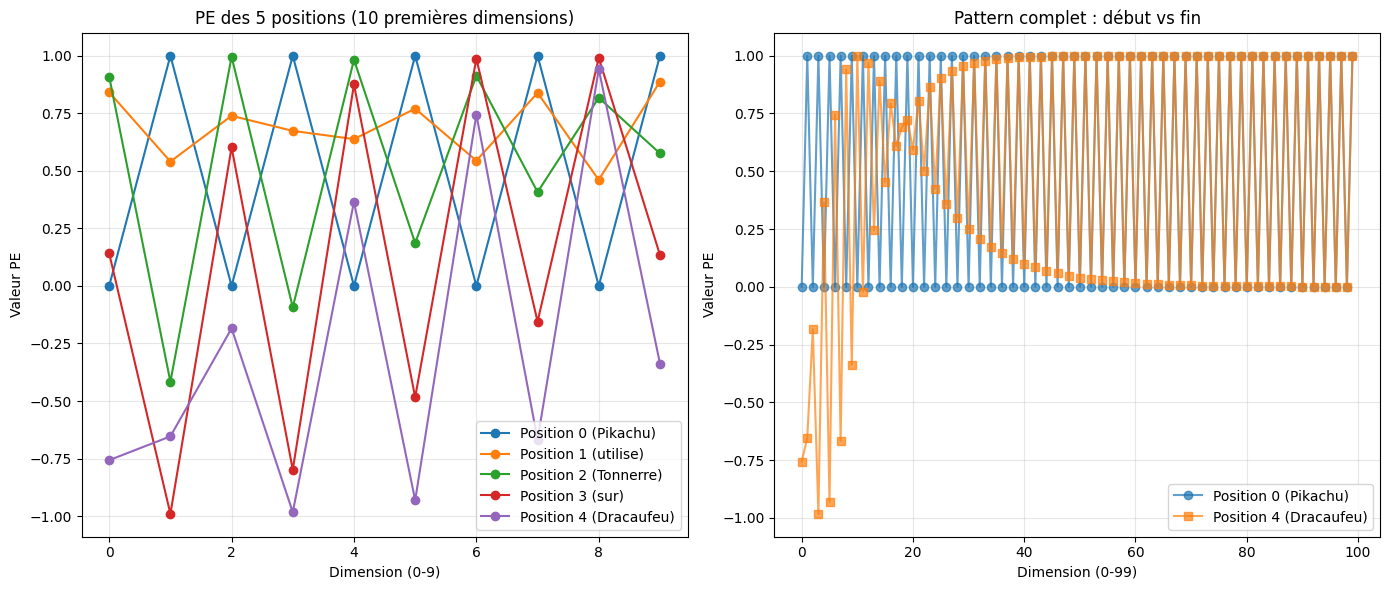

In [ ]:
import matplotlib.pyplot as plt

# Afficher les PE de toutes les positions
pe = get_positional_encoding(5, 100)

plt.figure(figsize=(14, 6))

# Subplot 1 : Les 10 premières dimensions
plt.subplot(1, 2, 1)
for pos in range(5):
    plt.plot(range(10), pe[pos, :10].numpy(),
             marker='o', label=f"Position {pos} ({phrase[pos]})")
plt.xlabel("Dimension (0-9)")
plt.ylabel("Valeur PE")
plt.title("PE des 5 positions (10 premières dimensions)")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2 : Pattern complet pour positions 0 et 4
plt.subplot(1, 2, 2)
plt.plot(pe[0, :].numpy(), 'o-', label='Position 0 (Pikachu)', alpha=0.7)
plt.plot(pe[4, :].numpy(), 's-', label='Position 4 (Dracaufeu)', alpha=0.7)
plt.xlabel("Dimension (0-99)")
plt.ylabel("Valeur PE")
plt.title("Pattern complet : début vs fin")
plt.legend()
plt.grid(True, alpha=0.3)




### 3.1 Exercices sur le Positional Encoding

Comparons deux phrases avec **les mêmes mots dans un ordre différent** :
- Phrase A : "Pikachu attaque Dracaufeu"
- Phrase B : "Dracaufeu attaque Pikachu"

**Question** : Quelle est la différence entre les embeddings **avec** et **sans** PE ?

In [ ]:
print("=== EXERCICE 1 : Pourquoi le Positional Encoding ? ===\n")

# Deux phrases avec mêmes tokens, ordre différent
phrase_a = ["Pikachu", "attaque", "Dracaufeu"]
phrase_b = ["Dracaufeu", "attaque", "Pikachu"]

def get_same_embeddings(tokens):
    """Retourne embeddings identiques pour tokens identiques."""
    vocab = {"Pikachu": 0, "attaque": 1, "Dracaufeu": 2}
    torch.manual_seed(42)
    base = torch.randn(3, 100)
    return torch.stack([base[vocab[t]] for t in tokens])

emb_a = get_same_embeddings(phrase_a)
emb_b = get_same_embeddings(phrase_b)

print(f"Phrase A : {phrase_a}")
print(f"Phrase B : {phrase_b}")
print(f"\nShape embeddings A : {emb_a.shape}")
print(f"Shape embeddings B : {emb_b.shape}")

# TODO 1.1 : Calculez la différence entre les embeddings (sans PE)
# Indice : torch.norm(emb_a - emb_b)
diff_sans_pe = None

# TODO 1.2 : Pourquoi les embeddings sont-ils identiques ?



In [ ]:
print("=== EXERCICE 2 : Calculer le PE manuellement ===\n")

print("Calculons le PE pour d_model=4, seq_len=3")
print("\nFormule :")
print("  PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))")
print("  PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))\n")

# TODO 2.1 : Calculez PE(0, 0)

pe_0_0 = None

# TODO 2.2 : Calculez PE(0, 1)

pe_0_1 = None

# TODO 2.3 : Calculez PE(1, 0)

# Indice : utilisez math.sin(1)
pe_1_0 = None



=== EXERCICE 2 : Calculer le PE manuellement ===

Calculons le PE pour d_model=4, seq_len=3

Formule :
  PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
  PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))



In [ ]:
print("=== EXERCICE 3 : Vérifier les propriétés du PE ===\n")

seq_len_test = 10
pe_test = get_positional_encoding(seq_len_test, 100)

# TODO 3.1 : Vérifiez que toutes les valeurs ∈ [-1, 1]
min_val = None
max_val = None

# TODO 3.2 : Calculez la différence entre positions consécutives
diff_pos_0_1 = None
diff_pos_4_5 = None

# TODO 3.3 : Extrayez les dimensions 0 (sin) et 1 (cos)
dim_0_all_pos = None
dim_1_all_pos = None


=== EXERCICE 3 : Vérifier les propriétés du PE ===

PE généré : torch.Size([10, 100])



In [ ]:
print("=== EXERCICE 4 : Démonstration de l'impact du PE ===\n")

phrase_a = ["Le", "chat", "mange", "la", "souris"]
phrase_b = ["La", "souris", "mange", "le", "chat"]

# Calcul embeddings avec get_same_embeddings

# Récupération du positional encoding pour chacune des phrases (indice: inverser pe_a pour obtenir pe_b)

# Calcul des distances avec torch.norm

# comparer termes à termes, indice utiliser une boucle for



Ce que montre cet exercice, ce n’est pas que le PE “crée” du sens, mais qu’il permet au modèle de distinguer deux phrases contenant les mêmes mots dans un ordre différent.

---

## 4. Visualisation intuitive de l'attention

Avant de passer au code, prenons un moment pour comprendre visuellement ce que fait l'attention dans un Transformer. Cette étape nous permet de saisir quelles parties de la phrase sont "regardées" par chaque mot, et pourquoi certaines relations sont plus importantes que d'autres.

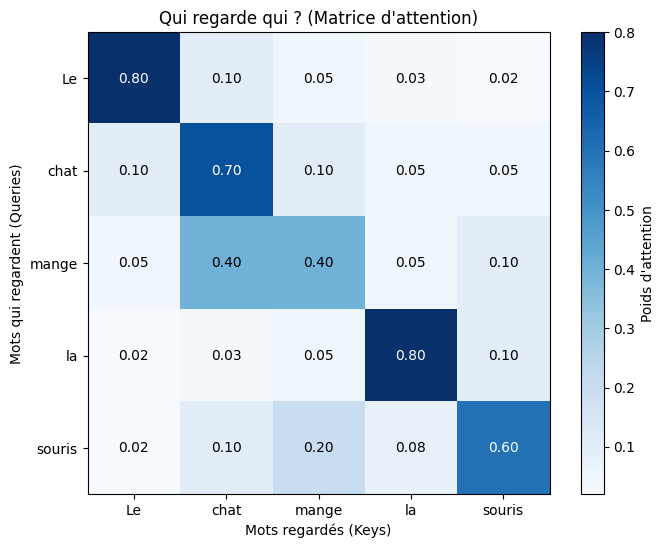

In [ ]:
# Exemple simple : attention dans une phrase
phrase = ["Le", "chat", "mange", "la", "souris"]

# Matrice d'attention simulée (quels mots regardent quels mots ?)
# Chaque ligne = un mot qui "regarde" les autres
attention_simulee = torch.tensor([
    [0.8, 0.1, 0.05, 0.03, 0.02],  # "Le" regarde surtout lui-même
    [0.1, 0.7, 0.1, 0.05, 0.05],   # "chat" regarde surtout lui-même
    [0.05, 0.4, 0.4, 0.05, 0.1],   # "mange" regarde "chat" et lui-même
    [0.02, 0.03, 0.05, 0.8, 0.1],  # "la" regarde surtout lui-même
    [0.02, 0.1, 0.2, 0.08, 0.6],   # "souris" regarde "mange" et elle-même
])

# Visualisation
plt.figure(figsize=(8, 6))
plt.imshow(attention_simulee, cmap='Blues')
plt.xticks(range(5), phrase)
plt.yticks(range(5), phrase)
plt.xlabel("Mots regardés (Keys)")
plt.ylabel("Mots qui regardent (Queries)")
plt.title("Qui regarde qui ? (Matrice d'attention)")
plt.colorbar(label="Poids d'attention")

# Afficher les valeurs
for i in range(5):
    for j in range(5):
        plt.text(j, i, f'{attention_simulee[i,j]:.2f}',
                ha='center', va='center',
                color='white' if attention_simulee[i,j] > 0.5 else 'black')
plt.show()

**Question** : Dans cette matrice, quel mot le verbe "mange" regarde-t-il le plus ? Pourquoi est-ce logique ?

### 4.1 Du TP1 à l'attention : Analogie entre similarité et produit scalaire


#### Rappel TP1 : Similarité cosinus

En TP1, nous avons utilisé la **similarité cosinus** pour mesurer la proximité entre mots :

$$\text{similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}$$

Exemple : `similarity("Pikachu", "Électrik") ≈ 0.85` (très similaires)

#### Lien avec l'attention

Le **produit scalaire** $Q \cdot K$ dans l'attention mesure exactement la même chose :

```
Similarité cosinus (TP1) :  A·B / (||A|| ||B||)   ← normalisation
Produit scalaire (Attention) :  Q·K                 ← pas de normalisation
```

**Différence** : L'attention utilise le produit scalaire **brut** (sans normaliser par les normes). Pourquoi ?
- Plus **rapide** à calculer (pas de division)
- La **magnitude** contient de l'information (mots importants = grande norme)
- Le **softmax** normalise de toute façon les scores

**En résumé** :

| TP1 | TP2 (Attention) |
|-----|----------------|
| Similarité cosinus | Produit scalaire Q·K |
| Mesure si deux mots sont sémantiquement proches | Mesure si un mot (Q) doit "regarder" un autre (K) |
| Normalisé par les normes | Normalisé par softmax + scaling |
| Valeurs entre -1 et 1 | Valeurs quelconques → softmax → [0,1] |

In [1]:
# Comparaison similarité cosinus vs produit scalaire
print("=" * 60)
print("SIMILARITÉ COSINUS vs PRODUIT SCALAIRE")
print("=" * 60)

# Créons deux vecteurs
v1 = torch.tensor([1.0, 2.0, 3.0])
v2 = torch.tensor([2.0, 3.0, 4.0])

# Produit scalaire
dot_product = torch.dot(v1, v2)

# Similarité cosinus
cos_sim = F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0))

# Version manuelle de la similarité cosinus
cos_sim_manual = dot_product / (torch.norm(v1) * torch.norm(v2))

print(f"\nVecteur 1 : {v1}")
print(f"Vecteur 2 : {v2}")
print(f"\nProduit scalaire : {dot_product:.4f}")
print(f"Similarité cosinus : {cos_sim.item():.4f}")
print(f"Similarité cosinus (manuel) : {cos_sim_manual:.4f}")

print("\n" + "=" * 60)
print("DANS L'ATTENTION")
print("=" * 60)

# Simulation Q et K
Q = torch.randn(3, 4)  # 3 tokens, dimension 4
K = torch.randn(3, 4)

# Scores d'attention (produit scalaire)
scores = Q @ K.T  # Chaque ligne de Q avec chaque ligne de K

print(f"\nQ shape : {Q.shape}")
print(f"K shape : {K.shape}")
print(f"Scores (Q @ K.T) shape : {scores.shape}")
print(f"\nScores d'attention (avant softmax) :")
print(scores)

# Softmax pour obtenir les poids
attention_weights = F.softmax(scores, dim=-1)
print(f"\nPoids d'attention (après softmax) :")
print(attention_weights)
print(f"\nSomme par ligne : {attention_weights.sum(dim=-1)} ← toujours 1.0")

print("\n✅ Le produit scalaire Q·K mesure la 'compatibilité' entre tokens")
print("   Le softmax transforme ces scores en probabilités d'attention")

SIMILARITÉ COSINUS vs PRODUIT SCALAIRE


NameError: name 'torch' is not defined

---

## 5. Scaled Dot-Product Attention

Le **Scaled Dot-Product Attention** est l'opération qui calcule la **matrice d'attention** (les poids "qui regarde qui") et produit les vecteurs enrichis en sortie.

La matrice d'attention est la matrice des poids d'attention, de taille (n × n), où chaque ligne correspond à un mot qui regarde les autres.

**Rappel des 3 vecteurs :**

| Vecteur | Rôle | Sert à... |
|---------|------|----------|
| **Q** (Query) | Ce que je cherche | Calculer les poids (avec K) |
| **K** (Key) | Mon identité / étiquette | Calculer les poids (avec Q) |
| **V** (Value) | Mon contenu / l'info que je transmets | Être récupéré selon les poids |

**Concrètement** : La matrice d'attention dit "à quel point chaque mot m'intéresse" (calculée avec Q et K). Ensuite on récupère l'**information** (V) de ces mots, pondérée par ces poids.

**Exemple** : Pour "dort" dans ["Le", "chat", "dort"], si les poids sont [0.26, 0.42, 0.32] :
- On récupère 26% du **contenu** (V) de "Le"
- On récupère 42% du **contenu** (V) de "chat"
- On récupère 32% du **contenu** (V) de "dort"

**Attention au vocabulaire** :
- `softmax(QK^T/√d_k)` = **matrice d'attention** (les poids)
- `Attention(Q,K,V)` = matrice d'attention × V = **sortie** (vecteurs enrichis)

### 5.1 La formule

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Où :
- $Q$ (Query) : Ce que je cherche - shape `(seq_len, d_k)`
- $K$ (Key) : Les étiquettes de ce qui est disponible - shape `(seq_len, d_k)`
- $V$ (Value) : Le contenu disponible - shape `(seq_len, d_v)`
- $d_k$ : Dimension des clés (pour normaliser)

> **Note** : Q, K, V sont obtenus à partir des embeddings via des matrices de poids apprenables. Cela permet à chaque mot d'avoir une représentation adaptée à son rôle (chercher, s'identifier, transmettre).

Il n'existe pas de "Query universelle" ou de "Key universelle" : Q, K et V sont appris par le modèle et dépendent entièrement de la tâche.

### 5.2 Exemple concret

Prenons la phrase **["Le", "chat", "dort"]** avec des embeddings de dimension 4.

Supposons qu'après transformation, on obtienne :

```
         Q (Queries)         K (Keys)           V (Values)
Le    → [0.1, 0.2, 0.1, 0.0]  [0.9, 0.1, 0.0, 0.2]  [1.0, 0.0, 0.0, 0.0]
chat  → [0.2, 0.8, 0.1, 0.3]  [0.2, 0.9, 0.2, 0.1]  [0.0, 1.0, 0.0, 0.0]
dort  → [0.3, 0.7, 0.2, 0.1]  [0.1, 0.3, 0.8, 0.1]  [0.0, 0.0, 1.0, 0.0]
```

**Calculons l'attention pour "dort"** (quelle info récupère-t-il des autres mots ?) :

**Étape 1 - Scores (Q·K^T)** : On compare la Query de "dort" aux Keys de tous les mots
```
Q_dort · K_Le   = 0.3×0.9 + 0.7×0.1 + 0.2×0.0 + 0.1×0.2 = 0.36
Q_dort · K_chat = 0.3×0.2 + 0.7×0.9 + 0.2×0.2 + 0.1×0.1 = 0.74  ← score élevé !
Q_dort · K_dort = 0.3×0.1 + 0.7×0.3 + 0.2×0.8 + 0.1×0.1 = 0.41

Scores = [0.36, 0.74, 0.41]
```

**Étape 2 - Scaling (÷√d_k)** : On divise par √4 = 2
```
Scaled = [0.18, 0.37, 0.205]
```

**Étape 3 - Softmax** : On transforme en probabilités
```
Poids = [0.26, 0.42, 0.32]  (somme = 1)
```

**Étape 4 - Output (poids × V)** : Moyenne pondérée des Values
```
Output_dort = 0.26 × V_Le + 0.42 × V_chat + 0.32 × V_dort
            = 0.26 × [1,0,0,0] + 0.42 × [0,1,0,0] + 0.32 × [0,0,1,0]
            = [0.26, 0.42, 0.32, 0.0]
```

**Interprétation** : La nouvelle représentation de "dort" contient **42% d'info de "chat"** (le sujet), **32% de lui-même** (le verbe), et **26% de "Le"** (le déterminant). Le modèle a appris que pour comprendre un verbe, il faut surtout regarder son sujet.

### 5.3 Décomposition étape par étape

1. **Scores** : $QK^T$ - Mesure la similarité entre queries et keys
2. **Scaling** : Division par $\sqrt{d_k}$ - Évite des valeurs trop grandes
3. **Softmax** : Transforme en probabilités (somme = 1)
4. **Output** : Multiplication par $V$ - Moyenne pondérée des values

### 5.4 Pourquoi softmax ? Pourquoi normaliser ?

**Le softmax** transforme des scores quelconques en **probabilités** :

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

```
Scores bruts :  [0.36, 0.74, 0.41]  (peuvent être négatifs, grands, etc.)
                        ↓ softmax
Probabilités :  [0.26, 0.42, 0.32]  (entre 0 et 1, somme = 1)
```

**Propriétés utiles** :
- Toutes les valeurs sont positives et somment à 1 → interprétables comme "pourcentage d'attention"
- Amplifie les différences : le score le plus élevé "gagne" plus de poids

**La normalisation (÷√d_k)** évite un problème quand la dimension est grande :

```
Sans normalisation (d_k = 512) :
  Scores Q·K → valeurs entre -50 et +50
  Softmax → [0.0001, 0.9998, 0.0001]  ← trop "peaked" !
  
Avec normalisation (÷√512 ≈ 22.6) :
  Scores → valeurs entre -2 et +2
  Softmax → [0.20, 0.45, 0.35]  ← distribution plus douce
```

Une distribution trop "peaked" pose problème : gradients très faibles → apprentissage difficile.

### 5.5 Exercice 1 : Calcul manuel des scores

Commençons par calculer les scores d'attention manuellement.

In [ ]:
# Exemple simple avec 3 mots et dimension 4
seq_len = 3
d_k = 4

# Créons des Query, Key, Value aléatoires
Q = torch.randn(seq_len, d_k)
K = torch.randn(seq_len, d_k)
V = torch.randn(seq_len, d_k)

print("Q (Queries):")
print(Q)
print(f"\nShape Q: {Q.shape}")
print(f"Shape K: {K.shape}")
print(f"Shape V: {V.shape}")

In [ ]:
# ============================================
# EXERCICE 1 : Calculez les scores d'attention
# ============================================

# Étape 1 : Calculer QK^T (produit matriciel)
# La transposée de K se note K.T

scores = None  # TODO: Calculer QK^T

print("Scores (QK^T):")
print(scores)
print(f"Shape: {scores.shape}")  # Devrait être (3, 3)

In [ ]:
# ============================================
# EXERCICE 2 : Appliquez le scaling
# ============================================

# Diviser par la racine de la dimension des vecteurs pour éviter des valeurs trop grandes

import math

scaled_scores = None  # TODO: scores / sqrt(d_k)

print("Scaled scores:")
print(scaled_scores)

In [ ]:
# ============================================
# EXERCICE 3 : Appliquez le softmax
# ============================================

# Le softmax transforme les scores en probabilités
# Chaque ligne doit sommer à 1
# Indice : F.softmax(tensor, dim=i) applique softmax sur la dimension i

attention_weights = None  # TODO: Appliquer softmax sur scaled_scores

print("Poids d'attention (après softmax):")
print(attention_weights)
print(f"\nVérification - Somme par ligne: {attention_weights.sum(dim=1)}")

In [ ]:
# ============================================
# EXERCICE 4 : Calculez la sortie finale
# ============================================

# Multiplier les poids d'attention par V
# C'est une moyenne pondérée des values

output = None  # TODO: attention_weights @ V

print("Output:")
print(output)
print(f"Shape: {output.shape}")  # Devrait être (3, 4)

---

## 6. Implémentation complète

### 6.1 Exercice 5 : Fonction d'attention

Maintenant, regroupez tout dans une fonction.

In [ ]:
def scaled_dot_product_attention(Q, K, V):
    """
    Calcule le Scaled Dot-Product Attention.

    Args:
        Q: Queries, shape (seq_len, d_k) ou (batch, seq_len, d_k)
        K: Keys, shape (seq_len, d_k) ou (batch, seq_len, d_k)
        V: Values, shape (seq_len, d_v) ou (batch, seq_len, d_v)

    Returns:
        output: Résultat de l'attention, shape (seq_len, d_v)
        attention_weights: Poids d'attention, shape (seq_len, seq_len)
    """
    # TODO: Récupérer d_k (dernière dimension de K)
    d_k=None
    # TODO: Implémenter les 4 étapes
    # 1. Calculer les scores : QK^T
    scores = None

    # 2. Scaling : diviser par sqrt(d_k)
    scaled_scores = None

    # 3. Softmax pour obtenir les poids
    attention_weights = None

    # 4. Moyenne pondérée : weights @ V
    output = None

    return output, attention_weights

In [ ]:
# Test de votre fonction
Q_test = torch.randn(4, 8)  # 4 tokens, dimension 8
K_test = torch.randn(4, 8)
V_test = torch.randn(4, 8)

output, weights = scaled_dot_product_attention(Q_test, K_test, V_test)

print(f"Structure de sortie: {output.shape}")  # Attendu: (4, 8)
print(f"Structure des poids: {weights.shape}")  # Attendu: (4, 4)
print(f"Somme des poids par ligne: {weights.sum(dim=1)}")  # Attendu: [1, 1, 1, 1]

---

### 6.2 Pourquoi diviser par √d_k ?

C'est une question importante ! Voyons l'effet du scaling.

In [ ]:
# Comparaison avec et sans scaling
d_k_grand = 512  # Dimension typique dans un Transformer

Q_grand = torch.randn(10, d_k_grand)
K_grand = torch.randn(10, d_k_grand)

# Scores sans scaling
scores_sans_scaling = Q_grand @ K_grand.T
attention_sans_scaling = F.softmax(scores_sans_scaling, dim=-1)

# Scores avec scaling
scores_avec_scaling = (Q_grand @ K_grand.T) / math.sqrt(d_k_grand)
attention_avec_scaling = F.softmax(scores_avec_scaling, dim=-1)

 # Fonction pour calculer l'entropie (avec epsilon pour éviter log(0))
def entropy(p, eps=1e-9):
  p_safe = p.clamp(min=eps)
  return -(p * p_safe.log()).sum(dim=-1).mean()


print("=== SANS SCALING ===")
print(f"Scores - min: {scores_sans_scaling.min():.2f}, max: {scores_sans_scaling.max():.2f}")
print(f"Attention max par ligne: {attention_sans_scaling.max(dim=-1).values}")
print(f"Entropie moyenne: {entropy(attention_sans_scaling):.4f}")

print("\n=== AVEC SCALING ===")
print(f"Scores - min: {scores_avec_scaling.min():.2f}, max: {scores_avec_scaling.max():.2f}")
print(f"Attention max par ligne: {attention_avec_scaling.max(dim=-1).values}")
print(f"Entropie moyenne: {entropy(attention_avec_scaling):.4f}")

**Observation** : Sans scaling, le softmax devient très "peaked" (une valeur proche de 1, les autres proches de 0). Le scaling permet une distribution plus douce et des gradients plus stables.

**Comment lire l'entropie ?**
- **Entropie haute** (~2.3 pour 10 tokens) → attention répartie sur plusieurs mots
- **Entropie basse** (~0) → attention concentrée sur un seul mot

**Nuance importante** : Une attention concentrée n'est pas toujours mauvaise ! Par exemple, dans *"Le chat dort, il ronfle"*, le mot "il" DOIT regarder "chat" à 95%.

Le problème c'est quand l'attention est peaked **par défaut** (artefact numérique du softmax saturé) plutôt que **par apprentissage**. Le scaling permet au modèle de **choisir** entre attention concentrée ou distribuée selon ce qui est pertinent.

---

## 7. Module nn.Module : Self-Attention

### 7.1 Self-Attention vs Cross-Attention

Jusqu'ici, on a manipulé Q, K, V comme des tenseurs indépendants. Mais d'où viennent-ils ?

**Self-Attention** (ce qu'on fait ici) :
- Q, K, V sont tous calculés à partir du **même** input `x`
- Chaque mot de la phrase regarde les autres mots **de la même phrase**
- C'est le cas dans BERT, GPT, et la plupart des Transformers

```
x (embeddings) ──┬──► W_q ──► Q
                 ├──► W_k ──► K    (même source x)
                 └──► W_v ──► V
```

**Cross-Attention** (on verra dans les projets) :
- Q vient d'une source, K et V d'une **autre** source
- Exemple : en traduction, le décodeur (français) "interroge" l'encodeur (anglais)
- Utilisé dans les architectures encodeur-décodeur

```
x_decoder ──► W_q ──► Q
x_encoder ──┬──► W_k ──► K    (sources différentes)
            └──► W_v ──► V
```

> **Dans ce TP**, on implémente la **self-attention** : la séquence "s'attentionne elle-même".

### 7.2 D'où viennent Q, K, V ?

Dans les exercices 1-5, on a utilisé des tenseurs aléatoires (`torch.randn`) pour comprendre le mécanisme d'attention. Mais en pratique, **Q, K, V sont calculés à partir des embeddings de la phrase**.

**Le point clé** : Un même mot a besoin de **3 représentations différentes** selon son rôle :

| Rôle | Représentation | Question posée |
|------|----------------|----------------|
| **Query** | `Q = x @ W_q` | "Qu'est-ce que je cherche ?" |
| **Key** | `K = x @ W_k` | "Comment les autres me voient ?" |
| **Value** | `V = x @ W_v` | "Quelle info je transmets ?" |

**Exemple concret** :

```
Phrase : "Le chat dort"

x = embeddings de la phrase (3 mots × embed_dim)

Q = x @ W_q  →  chaque mot "formule sa question"
K = x @ W_k  →  chaque mot "affiche son identité"
V = x @ W_v  →  chaque mot "prépare son contenu à transmettre"
```

**Pourquoi 3 matrices différentes ?**

Si on faisait simplement `Q = K = V = x`, le modèle serait limité. Les matrices W_q, W_k, W_v sont **apprises** pendant l'entraînement : le modèle découvre quelles "facettes" de chaque mot sont utiles pour chaque rôle.

> **C'est ce qu'on implémente dans l'exercice 6** : une classe qui projette `x` vers Q, K, V, puis applique l'attention.

### 7.3 Exercice 6 : Classe SelfAttention en PyTorch

Créons une classe PyTorch réutilisable qui :
1. Projette l'input `x` vers Q, K, V avec des matrices apprenables
2. Applique la fonction `scaled_dot_product_attention` de l'exercice 5

In [ ]:
class SelfAttention(nn.Module):
    """
    Module de Self-Attention.

    Projette l'input x vers Q, K, V puis applique l'attention.
    """

    def __init__(self, embed_dim):
        """
        Args:
            embed_dim: Dimension des embeddings d'entrée
        """
        super().__init__()
        self.embed_dim = embed_dim

        # TODO: Créer 3 couches linéaires pour projeter vers Q, K, V
        # Chaque couche : embed_dim -> embed_dim (utiliser nn.Linear)
        self.W_q = None
        self.W_k = None
        self.W_v = None

    def forward(self, x):
        """
        Args:
            x: Embeddings, shape (batch, seq_len, embed_dim)

        Returns:
            output: Résultat de l'attention
            attention_weights: Poids d'attention
        """
        # TODO: Projeter x vers Q, K, V en utilisant les couches linéaires
        Q = None
        K = None
        V = None

        # TODO: Réutiliser la fonction scaled_dot_product_attention de l'exercice 5
        # (elle fonctionne aussi avec des tenseurs 3D grâce à .transpose(-2, -1))
        output, attention_weights = None, None

        return output, attention_weights

In [ ]:
# Test du module
embed_dim = 32
batch_size = 2
seq_len = 5

attention_layer = SelfAttention(embed_dim)
x = torch.randn(batch_size, seq_len, embed_dim)

output, weights = attention_layer(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")  # Attendu: (2, 5, 32)
print(f"Weights shape: {weights.shape}")  # Attendu: (2, 5, 5)

---

## 8. Visualiser l'attention d'un vrai modèle

Maintenant qu'on a compris et implémenté le mécanisme, regardons ce que ça donne sur un modèle **réellement entraîné**.

### 8.1 Tokens spéciaux : [CLS] et [SEP]

Les modèles BERT ajoutent des tokens spéciaux :

| Token | Rôle |
|-------|------|
| **[CLS]** | Début de phrase. Son vecteur représente toute la phrase. |
| **[SEP]** | Fin de phrase / séparateur. |

Exemple : `"The cat sat"` → `[CLS] The cat sat [SEP]`

> **Note** : [CLS] reçoit souvent beaucoup d'attention, c'est normal !

### 8.2 Aperçu : Multi-Head

DistilBERT utilise **12 têtes d'attention par couche**. Chaque tête capture des relations différentes (syntaxe, coréférence, proximité...).

> **On étudiera le Multi-Head en détail dans le TP 03.** Ici, on visualise une tête qui capture bien la coréférence.

In [ ]:
# Installation de la librairie transformers
!pip install transformers -q

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Charger un petit modèle pré-entraîné
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()

# Phrase de test (en anglais pour ce modèle)
phrase = "The cat sat on the mat because it was tired"

# Tokenizer la phrase
inputs = tokenizer(phrase, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Forward pass (sans calculer les gradients)
with torch.no_grad():
    outputs = model(**inputs)

# Extraire les attentions
attentions = outputs.attentions

print(f"Phrase: {phrase}")
print(f"Tokens: {tokens}")
print(f"Nombre de couches: {len(attentions)}")
print(f"Nombre de têtes par couche: {attentions[0].shape[1]}")

In [ ]:
# Visualiser l'attention d'une tête spécifique
# Couche 5, Tête 2 : capture bien la coréférence "it" → "cat"
layer = 4   # Couche 5 (index 0-5)
head = 1    # Tête 2 (index 0-11)

attention_matrix = attentions[layer][0, head].numpy()

plt.figure(figsize=(10, 8))
plt.imshow(attention_matrix, cmap='Blues')
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.yticks(range(len(tokens)), tokens)
plt.xlabel("Tokens regardés (Keys)")
plt.ylabel("Tokens qui regardent (Queries)")
plt.title(f"Attention réelle - Couche {layer+1}, Tête {head+1}")
plt.colorbar(label="Poids d'attention")

for i in range(len(tokens)):
    for j in range(len(tokens)):
        val = attention_matrix[i, j]
        plt.text(j, i, f'{val:.2f}', ha='center', va='center',
                color='white' if val > 0.3 else 'black', fontsize=7)
plt.tight_layout()
plt.show()

In [ ]:
# Que regarde le pronom "it" ?
it_index = tokens.index("it")

print(f"Attention de 'it' (Couche {layer+1}, Tête {head+1}) :")
print("-" * 40)

for token, weight in zip(tokens, attention_matrix[it_index]):
    bar = "█" * int(weight * 30)
    highlight = " ← antécédent !" if token == "cat" else ""
    print(f"  {token:10} {weight:.2f} {bar}{highlight}")

**Observations :**

1. Le pronom "it" regarde principalement "cat" → le modèle a appris la **coréférence** !

2. Pourquoi pas "mat" ? Sémantiquement, "it was tired" fait référence à un être vivant (le chat), pas au tapis.

**Question :**

Essayez avec `"The trophy didn't fit in the suitcase because it was too big"`.

Qui est "it" ? Le trophée (trop gros pour rentrer) ou la valise (trop petite) ? C'est un cas **ambigu** !

> **Note sur l'interprétabilité** : Les poids d'attention donnent une **intuition** sur ce que le modèle "regarde", mais l'interprétation formelle du raisonnement des Transformers reste un **problème ouvert en recherche**.

---

## 9. Récapitulatif

### Ce que nous avons appris

1. **L'attention** permet à chaque élément de "regarder" tous les autres
2. **Q, K, V** : Query (ce que je cherche), Key (les étiquettes), Value (le contenu)
3. **Formule** : $\text{softmax}(QK^T / \sqrt{d_k}) \cdot V$
4. **Scaling** : Essentiel pour la stabilité des gradients

### Points clés

| Concept | Rôle |
|---------|------|
| Dot product $QK^T$ | Mesure la similarité |
| Softmax | Transforme en probabilités |
| Scaling $\sqrt{d_k}$ | Stabilise les gradients |
| Self-attention | Q, K, V viennent de la même source |

### Prochaine session

Nous verrons le **Multi-Head Attention** : plusieurs "têtes" d'attention qui regardent sous différents angles.

---

## 10. Pour aller plus loin (optionnel)

### Comment entraîne-t-on un Transformer ?

Il existe deux grandes approches selon l'usage du modèle :

### 10.1 Approche 1 : Prédire le mot suivant (GPT)

Pour les modèles **génératifs** (GPT, LLaMA, etc.), on entraîne le modèle à prédire le prochain mot.

**Objectif** : Entraîner efficacement sur des phrases entières en un seul forward pass.

```
Phrase : "Le chat dort sur"

Sans masque (inefficace) :
  Forward 1 : "Le"           → apprend à prédire "chat"
  Forward 2 : "Le chat"      → apprend à prédire "dort"
  Forward 3 : "Le chat dort" → apprend à prédire "sur"
  → 3 forward passes pour une phrase !

Avec masque causal (efficace) :
  Forward unique : "Le chat dort sur"
    Position 1 (voit "Le")           → apprend à prédire "chat"
    Position 2 (voit "Le chat")      → apprend à prédire "dort"
    Position 3 (voit "Le chat dort") → apprend à prédire "sur"
  → 1 seul forward pass, tout en parallèle !
```

**Le masque causal** permet à chaque position de ne voir que les mots précédents :

```
              Le   chat  dort  sur
      Le    [  ✓     ✗     ✗    ✗  ]
     chat   [  ✓     ✓     ✗    ✗  ]
     dort   [  ✓     ✓     ✓    ✗  ]
      sur   [  ✓     ✓     ✓    ✓  ]
```

**Implémentation** : On met `-∞` aux positions masquées → `softmax(-∞) = 0`

### 10.2 Approche 2 : Remplir les trous (BERT)

Pour les modèles de **compréhension** (BERT, RoBERTa, etc.) :

```
Entrée :    "Le [MASK] dort sur le [MASK]"
Objectif :   Prédire "chat" et "canapé"
```

Le modèle peut voir tout le contexte (gauche ET droite) pour deviner les mots masqués → pas besoin de masque causal.

### 10.3 Comparaison

| | GPT (génératif) | BERT (compréhension) |
|--|-----------------|---------------------|
| **Entraînement** | Prédire le mot suivant | Prédire les mots masqués |
| **Contexte** | Passé uniquement | Tout (bidirectionnel) |
| **Masque causal** | Oui | Non |
| **Usage** | Génération de texte | Classification, QA, NER |

### 10.4 Exercice bonus : Implémenter le masque causal

In [ ]:
# Créer un masque causal (triangulaire inférieur)
seq_len = 4
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

print("Masque causal (True = position masquée) :")
print(causal_mask.int())
print("\nVisuellement : chaque ligne ne peut voir que les positions ≤ à elle-même")

# Fonction d'attention avec masque
def scaled_dot_product_attention_with_mask(Q, K, V, mask=None):
    """Attention avec masque optionnel."""
    d_k = K.shape[-1]
    scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)

    if mask is not None:
        # Mettre -inf aux positions masquées → softmax donnera 0
        scores = scores.masked_fill(mask, float('-inf'))

    attention_weights = F.softmax(scores, dim=-1)
    output = attention_weights @ V
    return output, attention_weights

# Test avec masque
Q = torch.randn(seq_len, 8)
K = torch.randn(seq_len, 8)
V = torch.randn(seq_len, 8)

output_masked, weights_masked = scaled_dot_product_attention_with_mask(Q, K, V, causal_mask)

print("\nPoids d'attention avec masque causal:")
print(weights_masked.round(decimals=2))
print("\nObservation: chaque ligne ne peut voir que les positions précédentes (et elle-même)")